# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import numpy as np
import torchvision
import torch
import time
import random, os
import copy
import seaborn
import pandas


import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

from torch import nn, optim
from torch.autograd import Variable

import torch.nn.functional as F
from torch.optim import lr_scheduler
from collections import OrderedDict

from PIL import Image



## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
training_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


validation_transform = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

testing_transform  = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder

""""define batch size --> NOTE FOR SELF: keeping at 64 incase I train with cpu to avoid the neural network crashing. 
                                         If using only gpu, I can increase batch size to 128 for e.g or 256 etc.""" 
batch_s = 64
#define your training, validation and testing data (loading the datasets with ImageFolder)
training_data = datasets.ImageFolder(train_dir , transform = training_transform)
validation_data = datasets.ImageFolder(valid_dir , transform = validation_transform)
testing_data = datasets.ImageFolder(test_dir,transform = testing_transform )


# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(training_data, batch_size= batch_s, shuffle = True)

validloader = torch.utils.data.DataLoader(validation_data, batch_size= batch_s, shuffle=True)

testloader = torch.utils.data.DataLoader(testing_data, batch_size = batch_s, shuffle=True)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# TODO: Build and train your network

#defining device incase GPU isn't available, taken from my work on 
#part 8 - transfer learning exercise from the udacity curriculum

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define model - using vgg19
model = models.vgg19(pretrained = True)

# Freeze the parameters to avoid backpropogation
#(taken from my work on part 8 - transfer learning exercise from the udacity curriculum)
for param in model.parameters():
    param.requires_grad = False
#defining new untrained neural net which is feedforward, using ReLU functions and LogSoftmax for my output
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 2048)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(2048, 256)),
                          ('relu', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=0.2)),
                          ('fc3', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    

#(taken from my work on part 8 - transfer learning exercise from the udacity curriculum)
model.classifier = classifier
#defining criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:10<00:00, 52716118.09it/s]


In [7]:
#Training the network 
#Used the transfer learning lecture for help from the udacity curriculum
model = model.to(device)
epochs = 12
steps  = 0
running_loss = 0
print_every  = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        #training step for my model
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss  = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        #validation step (this is where I previously went wrong, didn't understand the need or anything for this part now 
        #I understand that this isnt part of the testing stage, it should be done with the training after creating the 
        #untrained model)
        #Got this wrong when asking my mentor help question, so use this new understanding to correctly implement validation 
        #loop
        
        #UPDATE FOR SELF: Implemented correctly
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}... "
                  f"Train loss: {running_loss/print_every:.3f}... "
                  f"Validation loss: {test_loss/len(validloader):.3f}... "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/12... Train loss: 6.075... Validation loss: 4.675... Validation accuracy: 0.095
Epoch 1/12... Train loss: 4.742... Validation loss: 3.875... Validation accuracy: 0.181
Epoch 1/12... Train loss: 4.066... Validation loss: 3.432... Validation accuracy: 0.255
Epoch 1/12... Train loss: 3.580... Validation loss: 3.106... Validation accuracy: 0.327
Epoch 1/12... Train loss: 3.470... Validation loss: 2.691... Validation accuracy: 0.357
Epoch 1/12... Train loss: 3.089... Validation loss: 2.507... Validation accuracy: 0.380
Epoch 1/12... Train loss: 2.930... Validation loss: 2.223... Validation accuracy: 0.464
Epoch 1/12... Train loss: 2.599... Validation loss: 2.084... Validation accuracy: 0.486
Epoch 1/12... Train loss: 2.553... Validation loss: 1.872... Validation accuracy: 0.532
Epoch 1/12... Train loss: 2.278... Validation loss: 1.769... Validation accuracy: 0.514
Epoch 1/12... Train loss: 2.326... Validation loss: 1.691... Validation accuracy: 0.554
Epoch 1/12... Train loss: 1.998.

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set     
#Used the transfer learning lecture for help from the udacity curriculum
accuracy = 0
test_loss = 0
model.eval()
for images, labels in testloader:
    
    images, labels = images.to(device), labels.to(device)
    logps = model(images)
    loss = criterion(logps, labels)
    test_loss += loss.item()
                
    ps = torch.exp(logps)
    top_ps, top_class = ps.topk(1, dim =1)
    equality = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()


print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")
running_loss = 0
model.train()


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
# TODO: Save the checkpoint 
model.class_to_idx = training_data.class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'learning_rate': 0.01,
              'epochs': epochs,
              'batch_size': batch_s,
              'model': models.vgg19(pretrained=True),
              'classifier': model.classifier,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, 'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [6]:
# TODO: Write a function thahttps://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.htmlt loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    #torch.load(filepath, map_location=lambda storage, loc: storage)
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epochs = checkpoint['epochs']


In [7]:
# TODO: Process a PIL image for use in a PyTorch model
def process_image(image):
    #this will scale my images propely and return a numpy array
    image = Image.open(image)
    transforming_image = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    image = np.array(transforming_image(image))
    
    #spent time debugging this, realised in the end that this requires a pytorch tensor, before I was returning the image on 
    #its own, torch.from_numpy(image) fixed my error
    return torch.from_numpy(image)
    


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

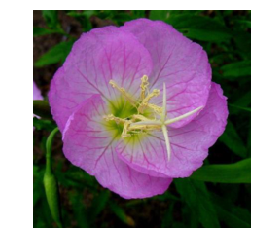

In [8]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.axis("off")
    if title is not None:
        ax.set_title(title)
    return ax

result = process_image('flowers/test/1/image_06764.jpg')

imshow(result)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [9]:
def class_predict(image_path, model, topk=5): 
    model.class_to_idx = training_data.class_to_idx
    image_torch = Image.open(image_path) 
    image_torch = process_image(image_path)
    image_torch = image_torch.unsqueeze_(0)

    model.eval()
    with torch.no_grad():
        #I did this to fix an error which asked to return a float_tensor
        image_torch = image_torch.float()
        #changed to model.forward(image_torch) from model.forward(image_path), mentor help suggested this as the reply to
        #my query. It is because I had tried to set logps to string in image_path when it needs a torch function as its
        #using model.forward
        logps = model.forward(image_torch.float())
        ps = torch.exp(logps)
        
        top_k_probs, top_class = ps.topk(topk, dim=1)
        # Get the first items in the tensor list to get the list of probs
        top_k_probs = top_k_probs.tolist()[0]

        
        #reversed the mapping, mentor help suggested my class_predict function was incomplete.
        #when re-reading the above help, it says to make sure I invert the mapping from idx to class
        model.idx_to_class = dict(map(reversed, model.class_to_idx.items()))
        
        #found this tip from mentor help as I was struggling to gather classes. I implemented it so it would also get the first
        #items in the tensor list, as I had an array within the tensor, hence the top_class[0].tolist() when looping through
        classes = [model.idx_to_class[idx] for idx in top_class[0].tolist()]
    
    return top_k_probs, classes

In [10]:
#test if class_predict works or not

image_path = 'flowers/test/1/image_06764.jpg'
top_k_probs, classes = class_predict(image_path, model)
print(top_k_probs)
print(classes)

[0.013275867328047752, 0.012900710105895996, 0.012366246432065964, 0.012233516201376915, 0.012050814926624298]
['69', '95', '45', '10', '94']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

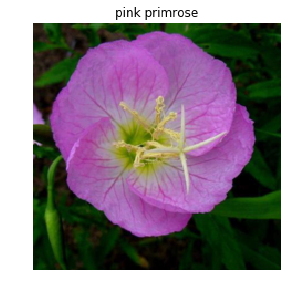

In [11]:
#TODO: Display an image along with the top 5 classes
#code up the plotting stuff
def sanity_check(model, image_path):
    
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    image = Image.open(image_path)

    #turn image_path to list, where each / gives a new element
    #eg ['flowers', 'test', '1', 'image_06764.jpg']
    flowerlist = image_path.split('/')
    #takes 3rd element of list (i.e the index of the particular flower, in this e.g '1')
    flowernum = flowerlist[2]
    #uses that index number thats retrieved to find the name from cat_to_name
    flowertitle = cat_to_name.get(flowernum)

    image = process_image(image_path)
    image2 = imshow(image, ax, flowertitle)
    
    return image2

sanity_check(model, image_path)



[0.013275867328047752, 0.012900710105895996, 0.012366246432065964, 0.012233516201376915, 0.012050814926624298]
['69', '95', '45', '10', '94']
['windflower', 'bougainvillea', 'bolero deep blue', 'globe thistle', 'foxglove']


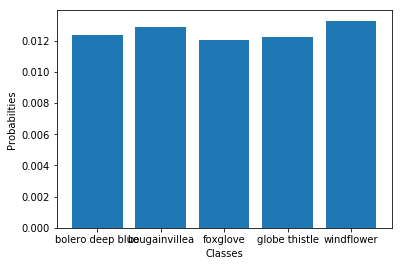

In [12]:
probabilities, classes = class_predict(image_path, model)

print(probabilities)
print(classes)

#convert key-value dictionary for cat_to_name.json, into a list of ONLY VALUES (names of the flowers) from classes

#used mentor help to complete, for some reason trying to for loop the old way didn't work. After studying array looping online
#I found a method where you have "dict[key] for key in elements of the dict you need" and this method has worked when I applied 
#it uniquely to my project. 
#NOTE TO SELF: use this method more as it seems quite neat and efficient for looping through dictionaries.
names = [cat_to_name[key] for key in classes]
print(names)

#here I ran into an error when having names on x-axis, the way we looped above has fixed this as I end up getting a
#a list of strings as elements as seen when I print(names) ---> THIS IS KEY FOR BAR PLOTS so take note of this for
#future work
plt.bar(names, probabilities)
plt.xlabel('Classes')
plt.ylabel('Probabilties')
plt.show()
